<a href="https://colab.research.google.com/github/divsal009/div/blob/master/3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import nibabel as nib
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [23]:
normal_scan_paths = [ os.path.join(os.getcwd(), "small_dataset/CT-0", x) for x in os.listdir("small_dataset/CT-0")]
abnormal_scan_paths = [ os.path.join(os.getcwd(), "small_dataset/CT-23", x) for x in os.listdir("small_dataset/CT-23")]

In [24]:
normal_scan_paths

['/content/drive/MyDrive/small_dataset/CT-0/study_0001.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0002.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0003.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0004.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0005.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0006.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0007.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0008.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0009.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-0/study_0010.nii.gz']

In [25]:
abnormal_scan_paths

['/content/drive/MyDrive/small_dataset/CT-23/study_0939.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0940.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0941.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0942.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0943.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0944.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0945.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0946.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0947.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0948.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0949.nii.gz',
 '/content/drive/MyDrive/small_dataset/CT-23/study_0950.nii.gz']

In [26]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [27]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:7], normal_scans[:7]), axis=0)
y_train = np.concatenate((abnormal_labels[:7], normal_labels[:7]), axis=0)
x_val = np.concatenate((abnormal_scans[7:], normal_scans[7:]), axis=0)
y_val = np.concatenate((abnormal_labels[7:], normal_labels[7:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 14 and 8.


In [28]:
x_train[0].shape

(128, 128, 64)

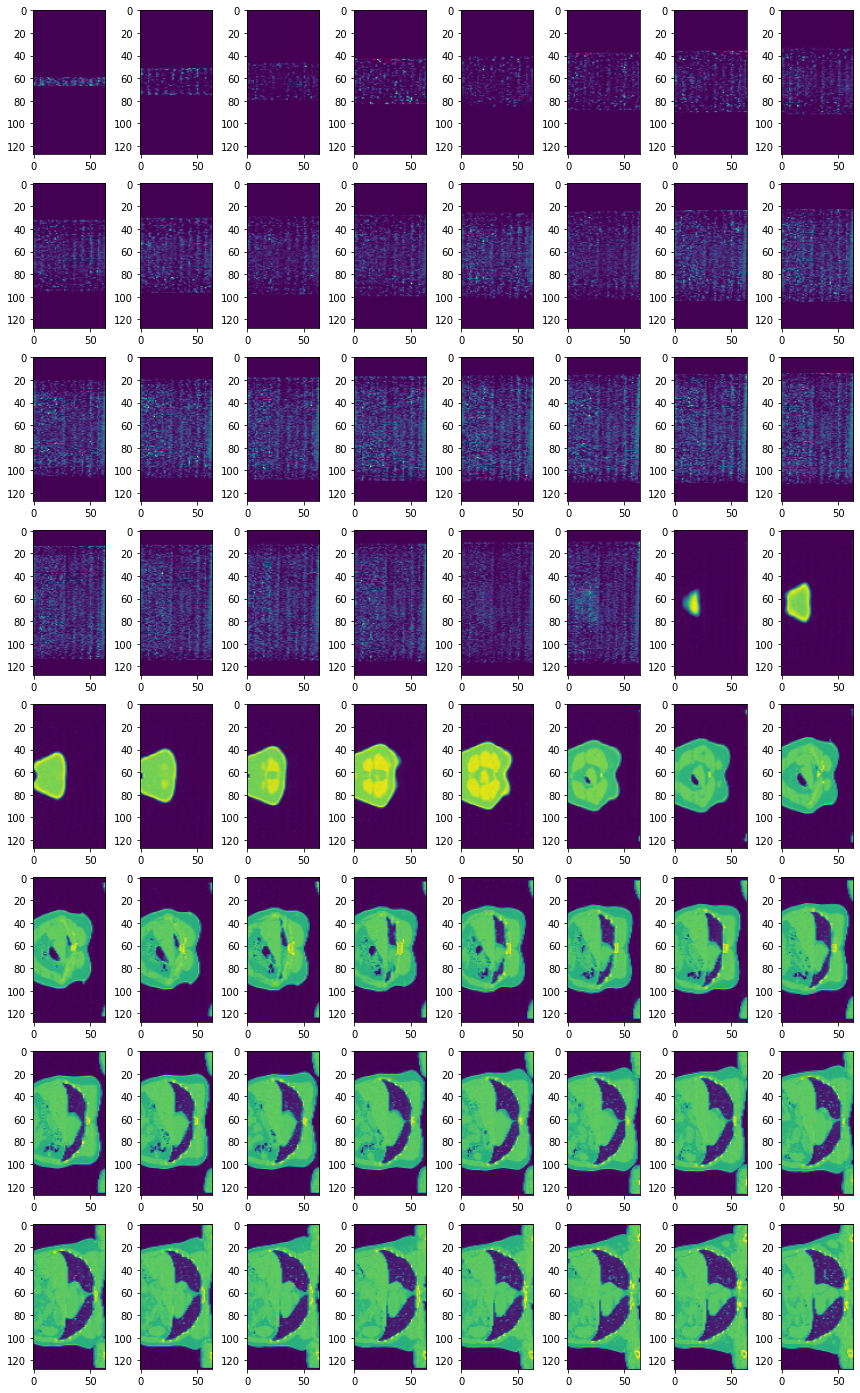

In [29]:
f, axarr = plt.subplots(8,8,figsize=(15,25))
for i in range(8):
  for j in range(8):
    axarr[i,j].imshow(x_train[0][i*8+j])
plt.show()

In [30]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 12, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 14, 6, 128)    0     

In [31]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),metrics=["acc"],)

In [32]:
epochs = 10
model.fit(x_train,y_train,epochs=epochs,batch_size=4)

Epoch 1/10
4/4 [==============================] - 35s 612ms/step - loss: 0.6999 - acc: 0.3571
Epoch 2/10
4/4 [==============================] - 1s 245ms/step - loss: 0.6942 - acc: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 242ms/step - loss: 0.6908 - acc: 0.5714
Epoch 4/10
4/4 [==============================] - 1s 242ms/step - loss: 0.6913 - acc: 0.5000
Epoch 5/10
4/4 [==============================] - 1s 244ms/step - loss: 0.6991 - acc: 0.4286
Epoch 6/10
4/4 [==============================] - 1s 244ms/step - loss: 0.6911 - acc: 0.5714
Epoch 7/10
4/4 [==============================] - 1s 245ms/step - loss: 0.6956 - acc: 0.5000
Epoch 8/10
4/4 [==============================] - 1s 245ms/step - loss: 0.6833 - acc: 0.5000
Epoch 9/10
4/4 [==============================] - 1s 246ms/step - loss: 0.6895 - acc: 0.5714
Epoch 10/10
4/4 [==============================] - 1s 244ms/step - loss: 0.6974 - acc: 0.4286


In [33]:
model.evaluate(x_val,y_val)

1/1 [==============================] - 1s 1s/step - loss: 0.6921 - acc: 0.6250


[0.6920599937438965, 0.625]